In [1]:
## Initialization

%matplotlib inline
import matplotlib
# matplotlib.use('AGG')
import LFPy
import numpy as np
import os
import sys
import nest
import scipy
from plotting_convention import *

import matplotlib.pyplot as plt
from os.path import join
from glob import glob

hbp_cells = '.'

sys.path.append(hbp_cells)
from hbp_cells import return_cell

l5_models = glob(join(".", 'L5_TTPC2*'))
cell_folder = l5_models[0]
cell_name = cell_folder.split('/')[-1]
print cell_folder


/home/karleh/.hashdist/bld/profile/bouzhaqj5ks4/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

./L5_TTPC2_cADpyr232_1


In [2]:
def soma_response(stim_amp, source_pos=[-70, 0, 0]):
    dt = 2**-4
    T = 100
    start_T = -200

    sigma = 0.3

    amp = stim_amp
    stim_start_time = 20

    n_tsteps = int(T / dt + 1)
    t = np.arange(n_tsteps) * dt

    sources_x = np.array([source_pos[0]])
    sources_y = np.array([source_pos[1]])
    sources_z = np.array([source_pos[2]])

    def ext_field(x, y, z):
	ef = 0
	for s_idx in range(len(sources_x)):
	    ef += 1 / (4 * np.pi * sigma * np.sqrt((sources_x[s_idx] - x) ** 2 +
						   (sources_y[s_idx] - y) ** 2 +
						   (sources_z[s_idx] - z) ** 2))
	return ef

    cell = return_cell(cell_folder, cell_name, T, dt, start_T)

    pulse = np.zeros(n_tsteps)
    start_time_idx = np.argmin(np.abs(t - stim_start_time))
    pulse[start_time_idx:] = amp

    v_cell_ext = np.zeros((cell.totnsegs, n_tsteps))
    v_cell_ext[:, :] = ext_field(cell.xmid, cell.ymid, cell.zmid).reshape(cell.totnsegs, 1) * pulse.reshape(1, n_tsteps)

    cell.insert_v_ext(v_cell_ext, t)
    print("running simulation...")
    cell.simulate(rec_imem=False, rec_isyn=True, rec_vmem=True)
    np.save('vmem_cell.npy', cell.vmem)
    vmem = cell.vmem
    # print '[', amp, ',', np.max(cell.somav) - cell.somav[start_time_idx - 1], '],'
    
    # change time coordinates so that stimulation starts at t=0
    return (t[start_time_idx-1:] - stim_start_time), cell.somav[start_time_idx-1:]
    

In [3]:
def point_neuron(Ie):
    nest.ResetKernel()
    
    n = nest.Create('iaf_psc_delta', params={'I_e': Ie})
    vm = nest.Create('voltmeter', params={'interval': 0.1})
    sd = nest.Create('spike_detector')
    
    nest.Connect(vm, n)
    nest.Connect(n, sd)

    nest.Simulate(50)
    vme = nest.GetStatus(vm, 'events')[0]
    return vme['times'], vme['V_m']


In [4]:
def RC_model(t, t0, V0, tau, Vp):
    return V0 + Vp*(1 - np.exp(-(t-t0)/tau))

def RC_fit(t, V):
    # fits curve to 
    f = 0.8
    
    V0 = V[0]			# resting potential
    t0 = t[0]			# start of stimulation

    U = V - V0
    s = t - t0

    V_plateau = U[-1]

    # choose tau s.t. model=data at voltage f*Vp
    s_target = s[np.argmin(np.abs(U/V_plateau - f))]
    tau = -s_target/np.log(1-f)
    
    return tau, V_plateau



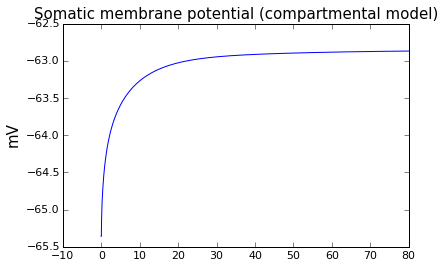


rec_imem = False, membrane currents will not be recorded!


Simulating  L5_TTPC2_cADpyr232_1
template cADpyr232_L5_TTPC2_8052133265 found!
template cADpyr232_L5_TTPC2_8052133265 found!
template cADpyr232_L5_TTPC2_8052133265 found!
Loading constants
template cADpyr232_L5_TTPC2_8052133265 exist already
running simulation...

In [9]:
comp_I = -6000.0
pos = [-150, 50, 0]
comp_t, comp_V = soma_response(comp_I, pos)
plt.plot(comp_t, comp_V)
plt.title('Somatic membrane potential (compartmental model)')
plt.ylabel('mV')



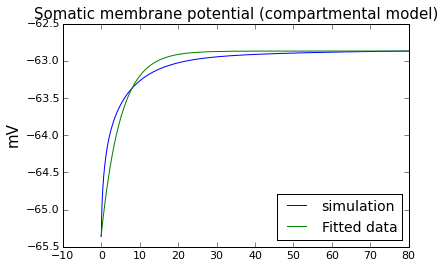

In [10]:

tau, Vp = RC_fit(comp_t, comp_V)
V_fit = RC_model(comp_t, comp_t[0], comp_V[0], tau, Vp)

plt.title('Somatic membrane potential (compartmental model)')
plt.ylabel('mV')

plt.plot(comp_t, comp_V, label="simulation")
plt.plot(comp_t, V_fit, label="Fitted data")
plt.legend(loc="lower right")
plt.show()





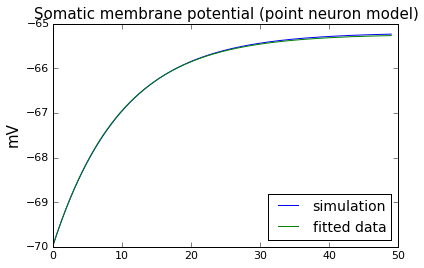

In [11]:
point_I = 120.
point_t, point_V = point_neuron(point_I)

plt.title('Somatic membrane potential (point neuron model)')
plt.ylabel('mV')
plt.plot(point_t, point_V, label="simulation")

tau, Vp = RC_fit(point_t, point_V)
V_fit = RC_model(point_t, point_t[0], point_V[0], tau, Vp)
plt.plot(point_t, V_fit, label="fitted data")
plt.legend(loc="lower right")
plt.show()
